# Seasonal SIRS with Quarter vs Calendar Seasons

We investigate seasonal transmission using an SIRS framework where β varies smoothly across seasons. 
We support two season schemes, equal quarters and explicit calendar boundaries, and keep the numerics identical across both. 
Our focus here is clarity and reproducibility: we separate utilities, simulation, visualization, and simple policy analyses while preserving the original code.

## Roadmap
1. Environment, plotting style, enums, colors.
2. Season schemes: equal quarters and calendar boundaries.
3. SIRS simulator with seasonal β and optional interventions.
4. Visualization: time series with shaded seasons; monthly heatmaps.
5. Sensitivity: immunity duration (ω = 1/duration).
6. Strategy analysis: seasonal reductions and cost-effectiveness.
7. Runner and main execution.
This notebook presents the model prior to validation on observed data.

## 1. Environment and basic definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import matplotlib.patches as mpatches

# Matplotlib style (optional)
plt.style.use('ggplot')
plt.rcParams.update({
    'font.size': 12,
    'figure.figsize': (14, 10),
    'axes.titlesize': 14,
    'axes.labelsize': 12
})

# 0) Enums and colors
SPRING = 0
SUMMER = 1
FALL   = 2
WINTER = 3

SEASON_COLORS = {
    SPRING: 'lightgreen',
    SUMMER: 'khaki',
    FALL:   'orange',
    WINTER: 'lightblue'
}

SEASON_NAMES = {
    SPRING: 'Spring',
    SUMMER: 'Summer',
    FALL:   'Fall',
    WINTER: 'Winter'
}

## 2. Season schemes

In [2]:
# 1) Season schemes

# 1A) Quarter-based (Jan–Mar Spring, Apr–Jun Summer, Jul–Sep Fall, Oct–Dec Winter)
def get_season_quarter(day, days_per_year=365):
    day_of_year = day % days_per_year
    season_length = days_per_year // 4
    if day_of_year < season_length:
        return SPRING
    elif day_of_year < 2 * season_length:
        return SUMMER
    elif day_of_year < 3 * season_length:
        return FALL
    else:
        return WINTER

def get_smooth_beta_quarter(t, beta_values, days_per_year=365, smoothing_days=10):
    day_of_year = t % days_per_year
    season_length = days_per_year // 4
    h = smoothing_days/2.0

    if day_of_year < season_length - h:
        return beta_values[SPRING]
    elif day_of_year < season_length + h:
        w_su = (day_of_year - (season_length - h))/ (2*h)
        w_sp = 1 - w_su
        return beta_values[SPRING]*w_sp + beta_values[SUMMER]*w_su
    elif day_of_year < 2*season_length - h:
        return beta_values[SUMMER]
    elif day_of_year < 2*season_length + h:
        w_fa = (day_of_year - (2*season_length - h))/(2*h)
        w_su = 1 - w_fa
        return beta_values[SUMMER]*w_su + beta_values[FALL]*w_fa
    elif day_of_year < 3*season_length - h:
        return beta_values[FALL]
    elif day_of_year < 3*season_length + h:
        w_wi = (day_of_year - (3*season_length - h))/(2*h)
        w_fa = 1 - w_wi
        return beta_values[FALL]*w_fa + beta_values[WINTER]*w_wi
    elif day_of_year < days_per_year - h:
        return beta_values[WINTER]
    else:
        w_sp = (day_of_year - (days_per_year - h))/(2*h)
        w_wi = 1 - w_sp
        return beta_values[WINTER]*w_wi + beta_values[SPRING]*w_sp

# Backward-compatibility names
get_season = get_season_quarter
get_smooth_beta = get_smooth_beta_quarter

In [3]:
# 1B) Calendar-based seasons via boundaries (month, day) for starts
# Canada example: Dec 1 winter, Mar 1 spring, Jun 1 summer, Sep 1 fall
SEASON_BOUNDARIES_CA = {
    SPRING: (3, 1),   # Mar 1
    SUMMER: (6, 1),   # Jun 1
    FALL:   (9, 1),   # Sep 1
    WINTER: (12, 1),  # Dec 1
}

def _season_starts_for_span(season_boundaries, ref_date):
    out = []
    for y in [ref_date.year-1, ref_date.year, ref_date.year+1]:
        for s in [SPRING, SUMMER, FALL, WINTER]:
            m, d = season_boundaries[s]
            out.append((datetime(y, m, d), s))
    out.sort(key=lambda x: x[0])
    return out

def get_season_calendar(date_obj, season_boundaries):
    starts = _season_starts_for_span(season_boundaries, date_obj)
    idx = max(i for i,(dt,_) in enumerate(starts[:-1]) if dt <= date_obj < starts[i+1][0])
    return starts[idx][1]

def get_smooth_beta_calendar(t, beta_values, start_date, season_boundaries, smoothing_days=10):
    d = start_date + timedelta(days=float(t))
    starts = _season_starts_for_span(season_boundaries, d)
    k = max(i for i,(dt,_) in enumerate(starts[:-1]) if dt <= d < starts[i+1][0])

    s_prev = starts[k-1][1]
    s_curr = starts[k][1]
    s_next = starts[k+1][1]
    curr_start = starts[k][0]
    next_start = starts[k+1][0]

    half = smoothing_days/2.0
    days_since = (d - curr_start).total_seconds()/86400.0
    days_to    = (next_start - d).total_seconds()/86400.0

    if 0 <= days_since < half:
        w = days_since/half
        return (1-w)*beta_values[s_prev] + w*beta_values[s_curr]
    if 0 <= days_to < half:
        w = days_to/half
        return (1-w)*beta_values[s_curr] + w*beta_values[s_next]
    return beta_values[s_curr]

## 3. SIRS simulator

In [4]:
# 2) Simulator with consistent β(t), incidence, and R_eff (supports both season schemes)
def simulate_quarterly_seasonal_sirs(beta_values, gamma, omega, duration_days, initial_conditions,
                                    intervention=None, noise_level=0.0, seed=None,
                                    start_date=datetime(2023, 1, 1),
                                    season_mode='calendar',            # 'calendar' or 'quarter'
                                    season_boundaries=SEASON_BOUNDARIES_CA,
                                    smoothing_days=10):
    """
    Simulate SIRS with seasonal β. 'calendar' uses season_boundaries (e.g., Canada seasons);
    'quarter' uses 4 equal-length seasons starting Jan 1.
    """
    if seed is not None:
        np.random.seed(seed)

    beta_values_copy = beta_values.copy()

    def beta_at_time(t):
        temp = beta_values_copy.copy()
        if intervention is not None and intervention['start_day'] <= t < intervention['end_day']:
            for season, reduction in intervention['season_reductions'].items():
                temp[season] *= (1 - reduction)
        if season_mode == 'calendar':
            return get_smooth_beta_calendar(t, temp, start_date, season_boundaries, smoothing_days)
        else:
            return get_smooth_beta_quarter(t, temp, days_per_year=365, smoothing_days=smoothing_days)

    def sirs_with_intervention(t, y):
        S, I, R = y
        beta = beta_at_time(t)
        dSdt = -beta * S * I + omega * R
        dIdt = beta * S * I - gamma * I
        dRdt = gamma * I - omega * R
        return [dSdt, dIdt, dRdt]

    solver_options = {'rtol': 1e-8, 'atol': 1e-10, 'max_step': 1.0}
    t_span = (0, duration_days)
    t_eval = np.arange(0, duration_days + 1, 1)

    solution = solve_ivp(
        sirs_with_intervention,
        t_span=t_span,
        y0=initial_conditions,
        t_eval=t_eval,
        method='RK45',
        **solver_options
    )

    S, I, R = solution.y
    times = solution.t
    dates = [start_date + timedelta(days=int(t)) for t in times]
    # Sanity check: population is conserved
    mass_err = np.max(np.abs(S + I + R - 1.0))
    if mass_err > 1e-6:
        print(f"[WARN] Mass balance drift = {mass_err:.3e} (check tolerances/time step)")


    beta_t = np.array([beta_at_time(t) for t in times])
    daily_new_infections = np.maximum(beta_t * S * I, 0)

    if noise_level > 0:
        I_observed = np.maximum(I * (1 + np.random.normal(0, noise_level, size=len(I))), 0)
        noisy_new_cases = np.maximum(daily_new_infections * (1 + np.random.normal(0, noise_level, size=len(daily_new_infections))), 0)
    else:
        I_observed = I
        noisy_new_cases = daily_new_infections

    R_effective = (beta_t / gamma) * S if gamma > 0 else np.zeros_like(S)

    if season_mode == 'calendar':
        seasons = [get_season_calendar(start_date + timedelta(days=int(t)), season_boundaries) for t in times]
    else:
        seasons = [get_season_quarter(int(t)) for t in times]

    results_df = pd.DataFrame({
        'Day': times,
        'Date': dates,
        'Susceptible': S,
        'Infected': I,
        'Recovered': R,
        'Infected_Observed': I_observed,
        'New_Cases': noisy_new_cases,
        'Beta': beta_t,
        'R_effective': R_effective,
        'Season': seasons,
        'Season_Name': [SEASON_NAMES[s] for s in seasons],
    })
    results_df['Year'] = results_df['Date'].dt.year
    results_df['Month'] = results_df['Date'].dt.month
    results_df['YearSeason'] = results_df['Year'].astype(str) + '-' + results_df['Season_Name']
    results_df['Immunity_Loss_Rate'] = omega

    return times, solution.y, results_df

## 4. Time series visualization

In [5]:
# 3) Plot: time series with season shading (works for either season scheme)
def plot_quarterly_seasonal_results(results_df, beta_values, gamma, omega, plot_title="Seasonal SIRS Model", intervention=None):
    R0_values = {season: beta/gamma for season, beta in beta_values.items()}
    fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

    # Compartments
    axes[0].plot(results_df['Date'], results_df['Susceptible'], label='Susceptible', color='blue', linewidth=2)
    axes[0].plot(results_df['Date'], results_df['Infected'],    label='Infected',    color='red',  linewidth=2)
    axes[0].plot(results_df['Date'], results_df['Recovered'],   label='Recovered',   color='green',linewidth=2)
    axes[0].set_ylim(0, 1.05)

    # Shade seasons
    season_changes = results_df['Season'].diff().fillna(0) != 0
    # Now let us include the very beginning so the first season is shaded too
    season_start_indices = [0] + results_df.index[season_changes].tolist()
    season_start_indices.append(len(results_df) - 1)

    seen_seasons = set()
    for i in range(len(season_start_indices)-1):
        start_idx = season_start_indices[i]
        end_idx   = season_start_indices[i+1]
        season    = results_df.iloc[start_idx]['Season']
        season_name = results_df.iloc[start_idx]['Season_Name']
        color     = SEASON_COLORS[season]
        label     = f"{season_name} (R0={R0_values[season]:.2f})" if season not in seen_seasons else None
        seen_seasons.add(season)
        for ax in axes:
            ax.axvspan(results_df.iloc[start_idx]['Date'], results_df.iloc[end_idx]['Date'], alpha=0.2, color=color, label=label)

    # Intervention markers
    if intervention is not None:
        start_day = intervention['start_day']
        end_day   = intervention['end_day']
        if start_day in results_df['Day'].values:
            start_date = results_df.loc[results_df['Day'] == start_day, 'Date'].iloc[0]
            axes[0].axvline(start_date, color='black', linestyle='--', label='Intervention Start')
            axes[1].axvline(start_date, color='black', linestyle='--')
            axes[2].axvline(start_date, color='black', linestyle='--')
        if end_day in results_df['Day'].values:
            end_date = results_df.loc[results_df['Day'] == end_day, 'Date'].iloc[0]
            axes[0].axvline(end_date, color='black', linestyle=':', label='Intervention End')
            axes[1].axvline(end_date, color='black', linestyle=':')
            axes[2].axvline(end_date, color='black', linestyle=':')

    axes[0].set_ylabel('Proportion of Population')
    axes[0].set_title(f'{plot_title} - Population Compartments')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)

    # New cases (daily)
    axes[1].bar(results_df['Date'], results_df['New_Cases'], color='purple', alpha=0.7, label='New Cases')
    axes[1].set_ylim(0, results_df['New_Cases'].max()*1.1)
    axes[1].set_ylabel('Daily New Cases')
    axes[1].set_title('Daily New Cases Over Time')
    axes[1].grid(True, alpha=0.3)

    # Effective R
    axes[2].plot(results_df['Date'], results_df['R_effective'], 'b-', label='Effective R', linewidth=2)
    axes[2].plot(results_df['Date'], results_df['Beta']/gamma,   'g--', label='Basic R0(t)', linewidth=1, alpha=0.6)
    axes[2].axhline(1, color='r', linestyle='--', label='Epidemic Threshold (R=1)')
    axes[2].set_ylim(0, max(results_df['R_effective'].max(), (results_df['Beta']/gamma).max())*1.1)
    axes[2].set_ylabel('Reproduction Number')
    axes[2].set_title('Reproduction Number Over Time')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    for ax in axes:
        ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # We now add extra legend entries on first axis
    legend_patches = [mpatches.Patch(color=SEASON_COLORS[s], alpha=0.2, label=f"{SEASON_NAMES[s]} (R0={R0_values[s]:.2f})") for s in [SPRING,SUMMER,FALL,WINTER]]
    immunity_duration = 1/omega if omega > 0 else float('inf')
    legend_patches.append(mpatches.Patch(color='white', alpha=0, label=f"Immunity Duration: {immunity_duration:.1f} days"))
    axes[0].legend(handles=legend_patches, loc='upper right')
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    return fig, axes

## 5. Monthly heatmaps

In [7]:
# 4) Heatmap (monthly totals) with season band matching the chosen scheme
def plot_seasonal_heatmap(results_df, value_column='New_Cases', title=None,
                          season_mode='calendar', season_boundaries=SEASON_BOUNDARIES_CA,
                          start_date=datetime(2023,1,1)):
    """
    Heatmap of monthly values.
    - For flows (New_Cases): monthly sum.
    - For state/rate variables (R_effective, Infected, Susceptible, Recovered, Beta): monthly mean.
    Season band matches the chosen season scheme.
    """
    if 'Year' not in results_df.columns:
        results_df['Year'] = results_df['Date'].dt.year
    if 'Month' not in results_df.columns:
        results_df['Month'] = results_df['Date'].dt.month

    # Decision on the aggregation rule
    flow_cols = {'New_Cases'}
    rate_or_state_cols = {'R_effective', 'Infected', 'Susceptible', 'Recovered', 'Beta'}
    if value_column in flow_cols:
        agg = 'sum'
        default_title = 'Monthly Total'
    else:
        agg = 'mean'
        default_title = 'Monthly Average'

    monthly_vals = results_df.groupby(['Year', 'Month'])[value_column].agg(agg).reset_index()
    heatmap_data = monthly_vals.pivot(index='Year', columns='Month', values=value_column).reindex(columns=range(1,13))

    fig, ax = plt.subplots(figsize=(12, 8))
    cmap = 'YlOrRd' if value_column in ['New_Cases', 'Infected'] else 'viridis'
    heatmap = ax.imshow(heatmap_data, cmap=cmap, aspect='auto')

    ax.set_yticks(range(len(heatmap_data.index)))
    ax.set_yticklabels(heatmap_data.index)
    month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    ax.set_xticks(range(12))
    ax.set_xticklabels(month_names)
    cbar = plt.colorbar(heatmap)
    cbar.set_label(value_column)

    # Season color band
    def month_to_season(month, year=2023):
        mid = datetime(year, month, 15)
        if season_mode == 'calendar':
            return get_season_calendar(mid, season_boundaries)
        else:
            q_day = (mid - datetime(mid.year,1,1)).days
            return get_season_quarter(q_day)

    season_colors = [SEASON_COLORS[month_to_season(m)] for m in range(1,13)]
    for i in range(12):
        ax.add_patch(plt.Rectangle((i-0.5, -0.5), 1, 0.25, color=season_colors[i], alpha=0.7))

    # Labels above band (calendar order)
    if season_mode == 'calendar':
        ax.text(1,  -0.45, 'Winter', ha='center', fontsize=10)
        ax.text(4,  -0.45, 'Spring', ha='center', fontsize=10)
        ax.text(7,  -0.45, 'Summer', ha='center', fontsize=10)
        ax.text(10, -0.45, 'Fall',   ha='center', fontsize=10)
    else:
        ax.text(1,  -0.45, 'Spring', ha='center', fontsize=10)
        ax.text(4,  -0.45, 'Summer', ha='center', fontsize=10)
        ax.text(7,  -0.45, 'Fall',   ha='center', fontsize=10)
        ax.text(10, -0.45, 'Winter', ha='center', fontsize=10)

    # Grid
    ax.set_xticks(np.arange(-0.5, 12, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(heatmap_data.index), 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=2)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

    # Cell labels
    for i in range(len(heatmap_data.index)):
        for j in range(len(heatmap_data.columns)):
            val = heatmap_data.iloc[i, j]
            if not np.isnan(val):
                ax.text(j, i, f"{val:.3f}", ha="center", va="center", color="black", fontsize=9)

    if title:
        ax.set_title(title, pad=25)
    else:
        ax.set_title(f'{default_title} {value_column} by Year', pad=25)

    ax.set_xlabel('Month')
    ax.set_ylabel('Year')
    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(top=0.9)
    return fig, ax

## 6. Immunity duration sensitivity

In [8]:
# 5) Immunity duration analysis helpers
def analyze_immunity_duration_impact(years=4, durations=[90, 180, 365, 730],
                                     season_mode='calendar', season_boundaries=SEASON_BOUNDARIES_CA):
    beta_values = {SPRING: 0.3, SUMMER: 0.2, FALL: 0.4, WINTER: 0.5}
    gamma = 0.2
    initial_conditions = [0.999, 0.001, 0.0]
    duration_days = 365 * years

    results = {}
    for duration in durations:
        omega = 1/duration if duration > 0 else 0
        _, _, sim_results = simulate_quarterly_seasonal_sirs(
            beta_values, gamma, omega, duration_days, initial_conditions,
            intervention=None, noise_level=0.01, seed=42,
            start_date=datetime(2023,1,1),
            season_mode=season_mode, season_boundaries=season_boundaries, smoothing_days=10
        )
        results[f"{duration} days"] = sim_results
    return results

def plot_immunity_duration_comparison(immunity_results):
    fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)
    colors = plt.cm.viridis(np.linspace(0, 1, len(immunity_results)))

    for i, (duration, df) in enumerate(immunity_results.items()):
        axes[0].plot(df['Date'], df['Infected'], label=f"Immunity: {duration}", color=colors[i], linewidth=2)
    axes[0].set_ylim(0, max([df['Infected'].max()*1.1 for df in immunity_results.values()]))
    axes[0].set_ylabel('Proportion Infected')
    axes[0].set_title('Impact of Immunity Duration on Infection Dynamics')
    axes[0].legend(loc='upper left'); axes[0].grid(True, alpha=0.3)

    for i, (duration, df) in enumerate(immunity_results.items()):
        axes[1].plot(df['Date'], df['Susceptible'], label=f"Immunity: {duration}", color=colors[i], linewidth=2)
    axes[1].set_ylim(0, 1.05)
    axes[1].set_ylabel('Proportion Susceptible')
    axes[1].set_title('Impact of Immunity Duration on Susceptible Population')
    axes[1].legend(loc='lower left'); axes[1].grid(True, alpha=0.3)

    for i, (duration, df) in enumerate(immunity_results.items()):
        axes[2].plot(df['Date'], df['R_effective'], label=f"Immunity: {duration}", color=colors[i], linewidth=2)
    axes[2].axhline(y=1, color='r', linestyle='--', label='Epidemic Threshold (R=1)')
    r_max = max([df['R_effective'].max() for df in immunity_results.values()])
    axes[2].set_ylim(0, min(r_max * 1.1, 5))
    axes[2].set_ylabel('Effective Reproduction Number')
    axes[2].set_title('Impact of Immunity Duration on Effective Reproduction Number')
    axes[2].legend(); axes[2].grid(True, alpha=0.3)

    for ax in axes:
        ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    plt.tight_layout(); plt.subplots_adjust(hspace=0.3)
    return fig, axes

## 7. Seasonal strategies and cost-effectiveness

In [10]:
# 6) Strategy analysis (weekly incidence + cumulative averted)
def analyze_control_strategies(beta_values, gamma, omega, years=4, strategies=None,
                               season_mode='calendar', season_boundaries=SEASON_BOUNDARIES_CA):
    if strategies is None:
        strategies = [
            {'name': 'No Intervention', 'interventions': None},
            {'name': 'Winter-Only (30% reduction)',
             'interventions': {'start_day': 365, 'end_day': 365*years, 'season_reductions': {WINTER: 0.3}}},
            {'name': 'Fall-Winter (30% reduction)',
             'interventions': {'start_day': 365, 'end_day': 365*years, 'season_reductions': {FALL: 0.3, WINTER: 0.3}}},
            {'name': 'All-Season (Weighted)',
             'interventions': {'start_day': 365, 'end_day': 365*years, 'season_reductions': {SPRING:0.1, SUMMER:0.1, FALL:0.3, WINTER:0.4}}},
            {'name': 'Intensive Winter (50% reduction)',
             'interventions': {'start_day': 365, 'end_day': 365*years, 'season_reductions': {WINTER: 0.5}}}
        ]

    initial_conditions = [0.999, 0.001, 0.0]
    duration_days = 365 * years

    results = {}
    for strategy in strategies:
        _, _, sim_results = simulate_quarterly_seasonal_sirs(
            beta_values, gamma, omega, duration_days, initial_conditions,
            intervention=strategy['interventions'], noise_level=0.01, seed=42,
            season_mode=season_mode, season_boundaries=season_boundaries
        )
        results[strategy['name']] = sim_results
    return results

def compare_control_strategies(strategy_results,
                               title="Seasonal Control Strategies (4-Year Simulation)"):
    baseline_key = "No Intervention"

    def to_weekly(df):
        return df.resample('W-MON', on='Date').agg({'New_Cases':'sum'}).reset_index()

    baseline_weekly = to_weekly(strategy_results[baseline_key])

    strat_names = list(strategy_results.keys())
    colours = plt.cm.tab10(range(len(strat_names)))

    fig, axs = plt.subplots(3, 1, figsize=(13, 9), sharex=True,
                            gridspec_kw={"height_ratios": [1.2, 1, 1]})
    plt.subplots_adjust(hspace=0.35)

    for c, name in zip(colours, strat_names):
        axs[0].plot(strategy_results[name]["Date"], strategy_results[name]["Infected"], lw=2, color=c, label=name)
    axs[0].set_ylabel("Prevalence (I/N)")
    axs[0].set_ylim(0, max(df["Infected"].max() for df in strategy_results.values())*1.10)
    axs[0].set_title(f"{title}: prevalence, weekly incidence, and impact")
    axs[0].grid(alpha=0.3)

    weekly_dict = {}
    for c, name in zip(colours, strat_names):
        w = to_weekly(strategy_results[name])
        weekly_dict[name] = w
        axs[1].plot(w["Date"], w["New_Cases"], lw=1.8, color=c)
    axs[1].set_ylabel('Weekly new cases (sum)')
    axs[1].set_ylim(0, max(w["New_Cases"].max() for w in weekly_dict.values())*1.10)
    axs[1].grid(alpha=0.3)

    baseline_cum = weekly_dict[baseline_key]["New_Cases"].cumsum()
    for c, name in zip(colours[1:], strat_names[1:]):
        cum_cases = weekly_dict[name]["New_Cases"].cumsum()
        averted = baseline_cum - cum_cases
        axs[2].plot(weekly_dict[name]["Date"], averted, lw=2, color=c, label=name)
    axs[2].axhline(0, color="grey", lw=0.8)
    axs[2].set_ylabel("Cumulative cases averted")
    if axs[2].lines:
        ymax = max(np.max(line.get_ydata()) for line in axs[2].lines)
        axs[2].set_ylim(-0.05*ymax, 1.05*ymax)
    axs[2].grid(alpha=0.3)

    axs[2].set_xlabel("Simulation date")
    for ax in axs:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.xaxis.set_major_formatter(DateFormatter("%b%Y"))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="center")

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=min(3, len(labels)), frameon=False)
    fig.tight_layout(rect=[0, 0, 1, 0.92])
    return fig, axs

# bar chart helper
def plot_seasonal_contribution(strategy_results):
    seasonal_breakdown = {}
    for strategy_name, results in strategy_results.items():
        season_cases = results.groupby('Season_Name')['New_Cases'].sum()
        seasonal_breakdown[strategy_name] = season_cases

    fig, ax = plt.subplots(figsize=(12, 8))
    bar_width = 0.8 / len(strategy_results)
    season_names = list(SEASON_NAMES.values())
    strategy_colors = plt.cm.tab10.colors

    for i, (strategy_name, season_cases) in enumerate(seasonal_breakdown.items()):
        color = strategy_colors[i % len(strategy_colors)]
        positions = np.array(range(len(season_names))) + i * bar_width - bar_width * (len(strategy_results) - 1) / 2
        heights = [season_cases.get(season, 0) for season in season_names]
        ax.bar(positions, heights, bar_width, label=strategy_name, color=color, alpha=0.7)

    ax.set_xlabel('Season')
    ax.set_ylabel('Total Cases')
    ax.set_title('Total Cases by Season and Strategy')
    ax.set_xticks(range(len(season_names)))
    ax.set_xticklabels(season_names)
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, max([max(v) for v in seasonal_breakdown.values()]) * 1.1)

    for i, (strategy_name, season_cases) in enumerate(seasonal_breakdown.items()):
        positions = np.array(range(len(season_names))) + i * bar_width - bar_width * (len(strategy_results) - 1) / 2
        heights = [season_cases.get(season, 0) for season in season_names]
        for pos, height in zip(positions, heights):
            if height > 0.005:
                ax.text(pos, height * 1.02, f'{height:.3f}', ha='center', va='bottom', rotation=90, fontsize=8)

    plt.tight_layout()
    return fig, ax

def calculate_intervention_cost_effectiveness(strategy_results, cost_parameters):
    baseline_key = 'No Intervention'
    baseline_total_cases = strategy_results[baseline_key]['New_Cases'].sum()
    baseline_intervention_cost = cost_parameters['intervention_costs'].get(baseline_key, 0)
    baseline_disease_cost = cost_parameters['case_cost'] * baseline_total_cases
    baseline_total_cost = baseline_intervention_cost + baseline_disease_cost

    rows = []
    for strategy_name, results in strategy_results.items():
        total_cases = results['New_Cases'].sum()
        averted = max(baseline_total_cases - total_cases, 0)
        percent_reduction = 100 * averted / baseline_total_cases if baseline_total_cases > 0 else 0

        intervention_cost = cost_parameters['intervention_costs'].get(strategy_name, 0)
        disease_cost = cost_parameters['case_cost'] * total_cases
        total_cost = intervention_cost + disease_cost

        incr_total_cost = total_cost - baseline_total_cost
        incr_cost_per_case_averted = (incr_total_cost / averted) if averted > 0 else float('inf')

        rows.append({
            'Strategy': strategy_name,
            'Total Cases': total_cases,
            'Cases Averted': averted,
            'Percent Reduction': percent_reduction,
            'Intervention Cost': intervention_cost,
            'Disease Cost': disease_cost,
            'Total Cost': total_cost,
            'Incremental Total Cost vs Baseline': incr_total_cost,
            'Cost per Case Averted (intervention only)': (intervention_cost / averted) if averted > 0 else float('inf'),
            'Incremental Cost per Case Averted': incr_cost_per_case_averted
        })
    return pd.DataFrame(rows)

## 8. Runner and execution

In [13]:
# 7) Runner that uses calendar seasons by default (Canada)
def run_quarterly_seasonal_sirs_model():
    # We can choose season scheme here:
    SEASON_MODE = 'calendar'            # 'calendar' or 'quarter'
    SEASON_BOUNDARIES = SEASON_BOUNDARIES_CA  # used if SEASON_MODE=='calendar'
    beta_values = {SPRING: 0.3, SUMMER: 0.2, FALL: 0.4, WINTER: 0.5}
    gamma = 0.2
    immunity_duration = 365
    omega = 1 / immunity_duration
    initial_conditions = [0.999, 0.001, 0.0]
    years = 4
    duration_days = 365 * years
    
    # Base simulation
    _, _, results_df = simulate_quarterly_seasonal_sirs(
        beta_values, gamma, omega, duration_days, initial_conditions,
        noise_level=0.01, seed=42,
        season_mode=SEASON_MODE, season_boundaries=SEASON_BOUNDARIES
    )
    
    fig, axes = plot_quarterly_seasonal_results(
        results_df, beta_values, gamma, omega,
        plot_title=f"Seasonal SIRS Model ({years} Years)", intervention=None
    )
    
    # Heatmaps
    heatmap_fig, _ = plot_seasonal_heatmap(
        results_df, value_column='New_Cases',
        title="Monthly Total New Cases",
        season_mode=SEASON_MODE, season_boundaries=SEASON_BOUNDARIES
    )
    
    R_heatmap_fig, _ = plot_seasonal_heatmap(
        results_df, value_column='R_effective',
        title="Monthly Average Effective Reproduction Number",
        season_mode=SEASON_MODE, season_boundaries=SEASON_BOUNDARIES
    )
    
    # Immunity analysis
    immunity_results = analyze_immunity_duration_impact(
        years=years, durations=[90, 180, 365, 730],
        season_mode=SEASON_MODE, season_boundaries=SEASON_BOUNDARIES
    )
    
    immunity_fig, _ = plot_immunity_duration_comparison(immunity_results)
    
    # Control strategies
    strategy_results = analyze_control_strategies(
        beta_values, gamma, omega, years=years,
        season_mode=SEASON_MODE, season_boundaries=SEASON_BOUNDARIES
    )
    
    strategy_fig, _ = compare_control_strategies(
        strategy_results, title=f"Comparison of Seasonal Disease Control Strategies ({years} Years)"
    )
    
    seasonal_fig, _ = plot_seasonal_contribution(strategy_results)
    
    # Cost-effectiveness
    cost_parameters = {
        'case_cost': 1000,
        'intervention_costs': {
            'No Intervention': 0,
            'Winter-Only (30% reduction)': 200000,
            'Fall-Winter (30% reduction)': 300000,
            'All-Season (Weighted)': 400000,
            'Intensive Winter (50% reduction)': 350000
        }
    }
    
    cost_effectiveness = calculate_intervention_cost_effectiveness(strategy_results, cost_parameters)
    
    print("\nCost-Effectiveness (summary):")
    print(cost_effectiveness[['Strategy','Cases Averted','Percent Reduction','Intervention Cost','Total Cost','Incremental Cost per Case Averted']].to_string(index=False))
    
    return (results_df, fig, heatmap_fig, R_heatmap_fig, immunity_fig, strategy_fig, seasonal_fig, cost_effectiveness)


Cost-Effectiveness (summary):
                        Strategy  Cases Averted  Percent Reduction  Intervention Cost    Total Cost  Incremental Cost per Case Averted
                 No Intervention       0.000000           0.000000                  0   2331.049072                                inf
     Winter-Only (30% reduction)       0.308751          13.245149             200000 202022.298139                       6.467713e+05
     Fall-Winter (30% reduction)       0.709888          30.453603             300000 301621.160653                       4.216016e+05
           All-Season (Weighted)       0.992057          42.558402             400000 401338.991830                       4.022025e+05
Intensive Winter (50% reduction)       0.669920          28.738997             350000 351661.128942                       5.214503e+05


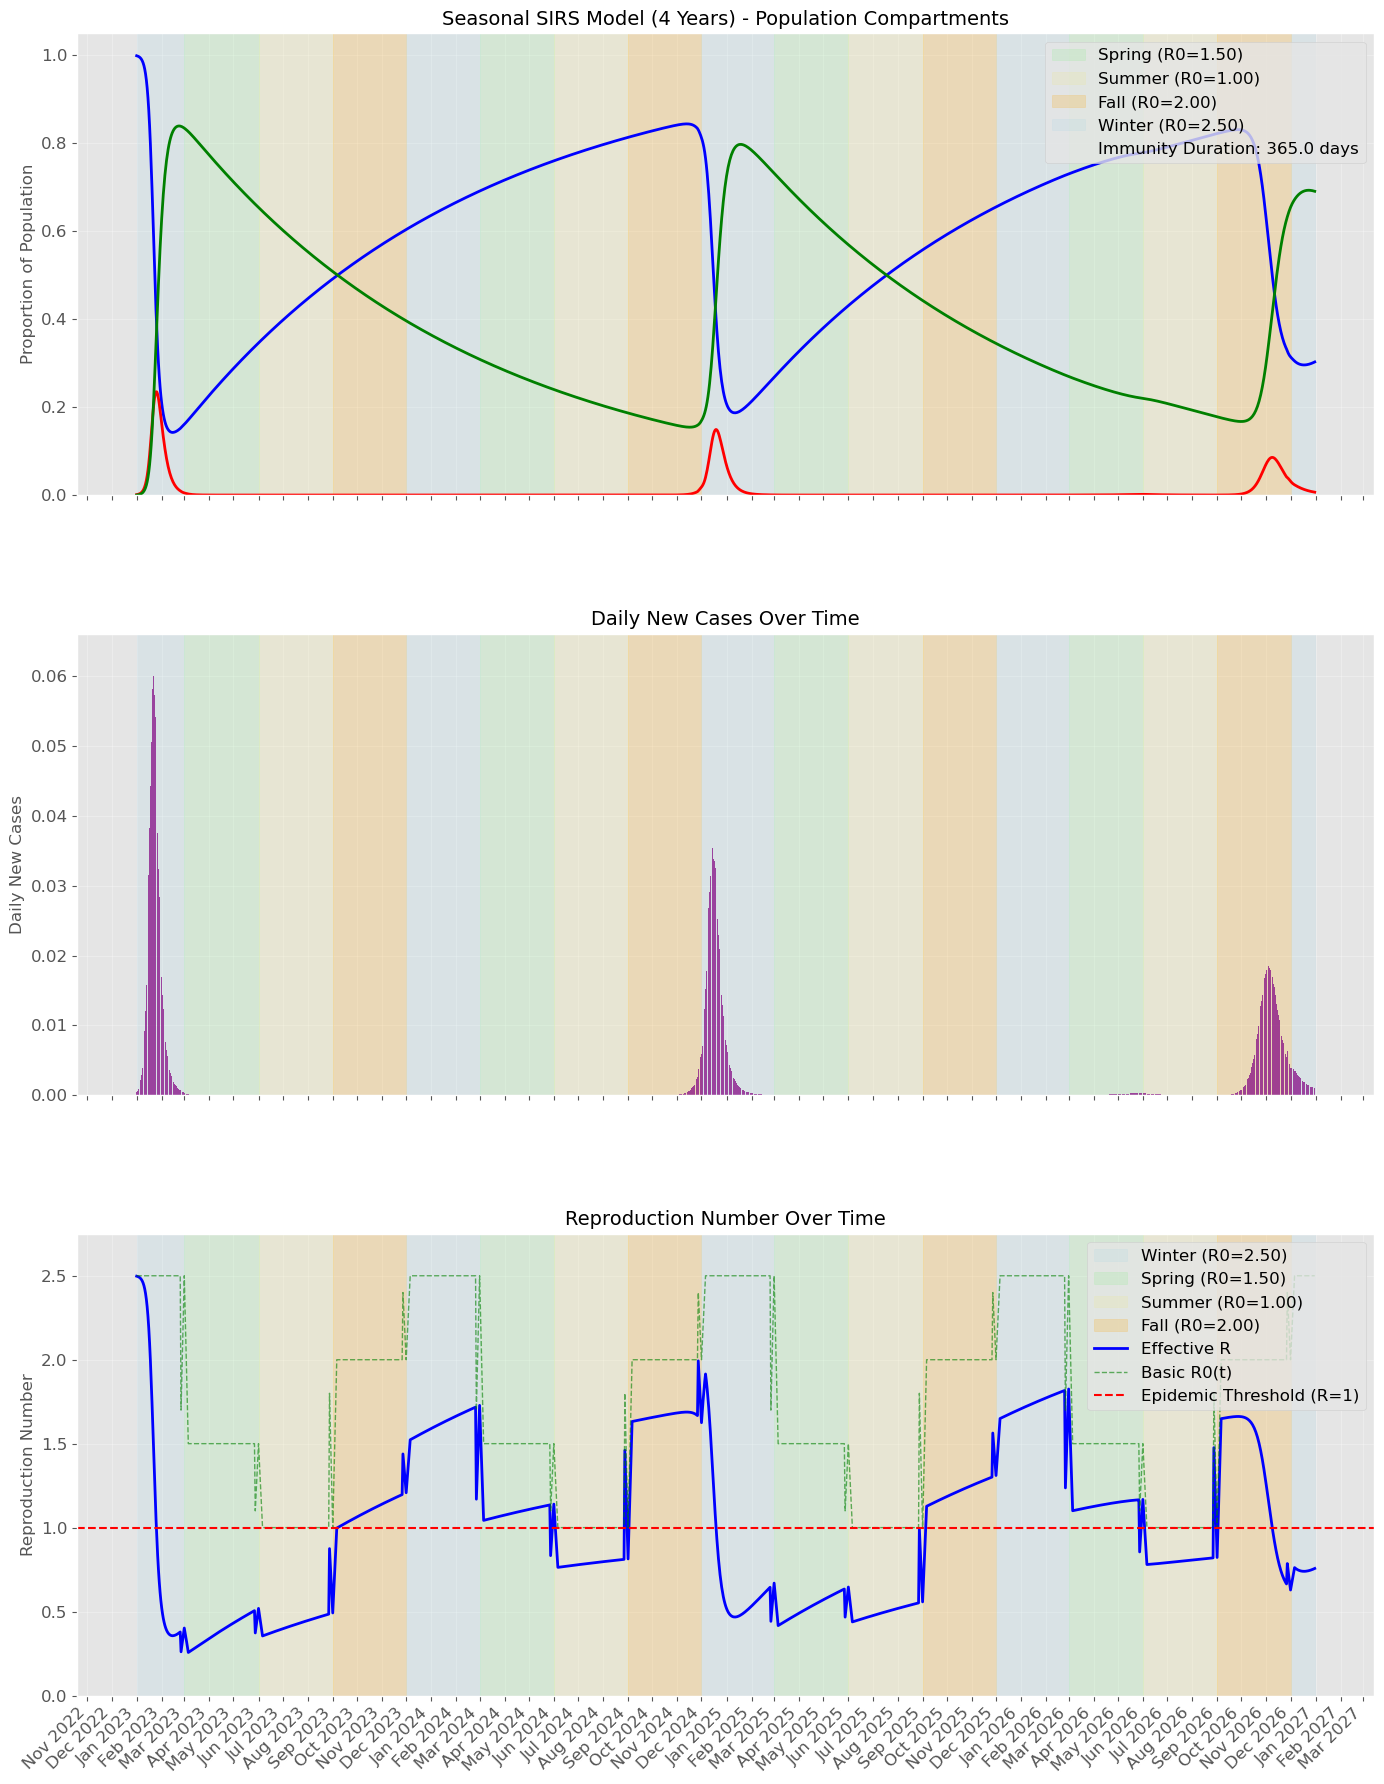

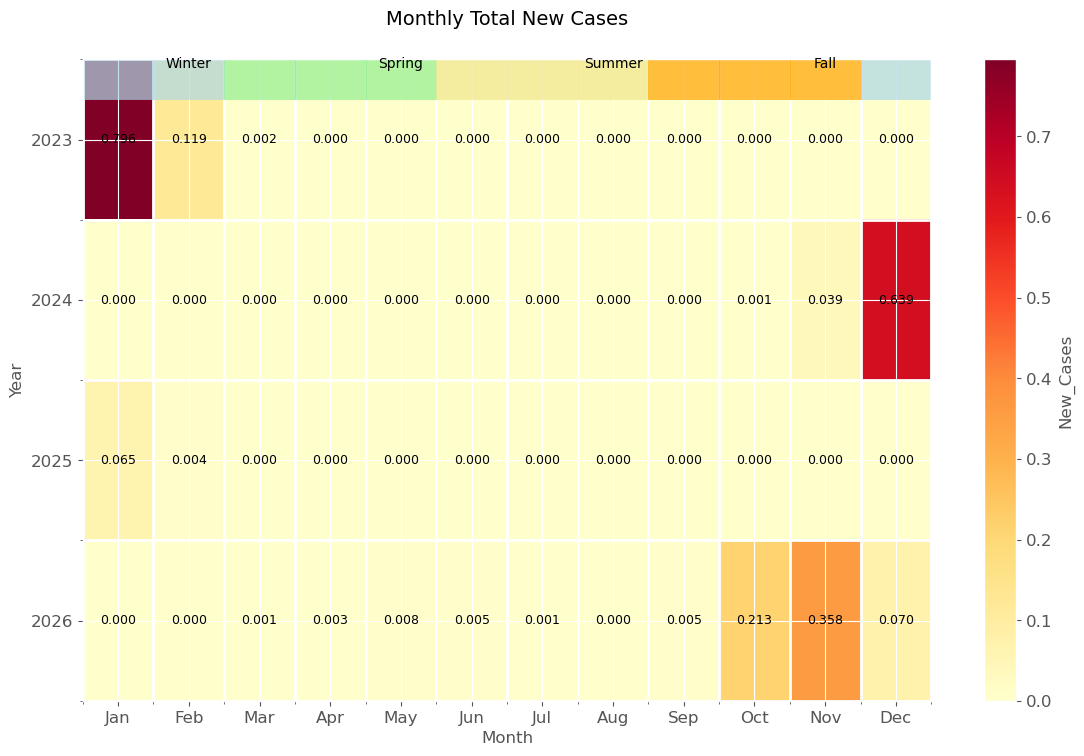

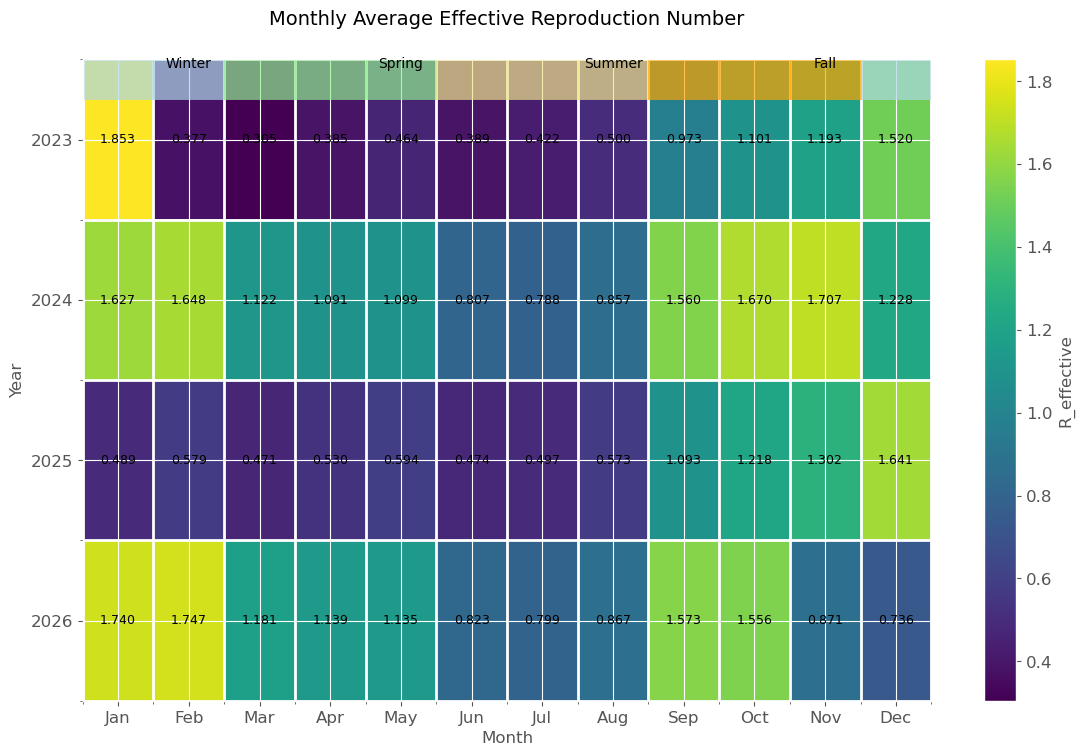

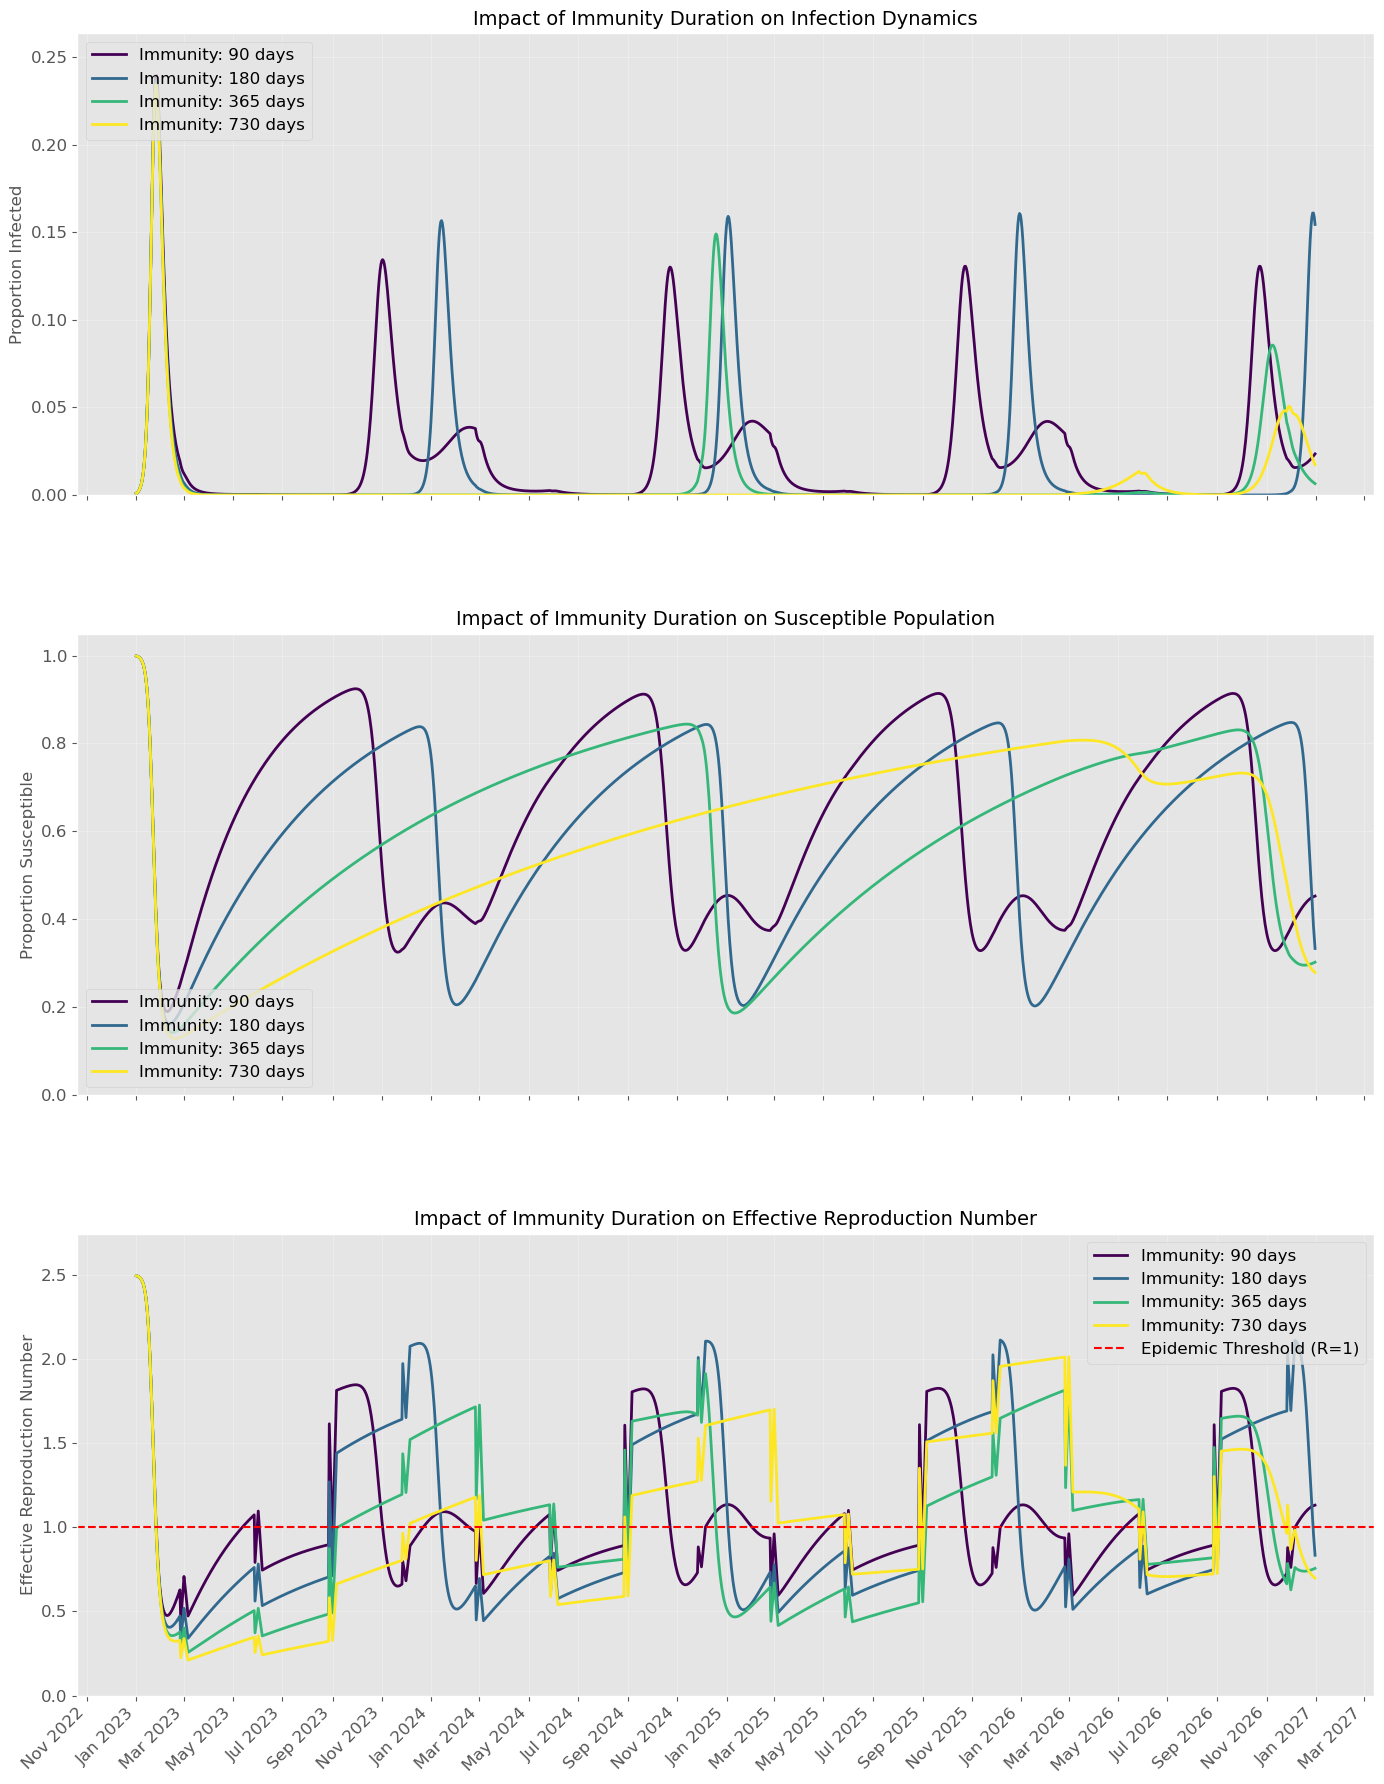

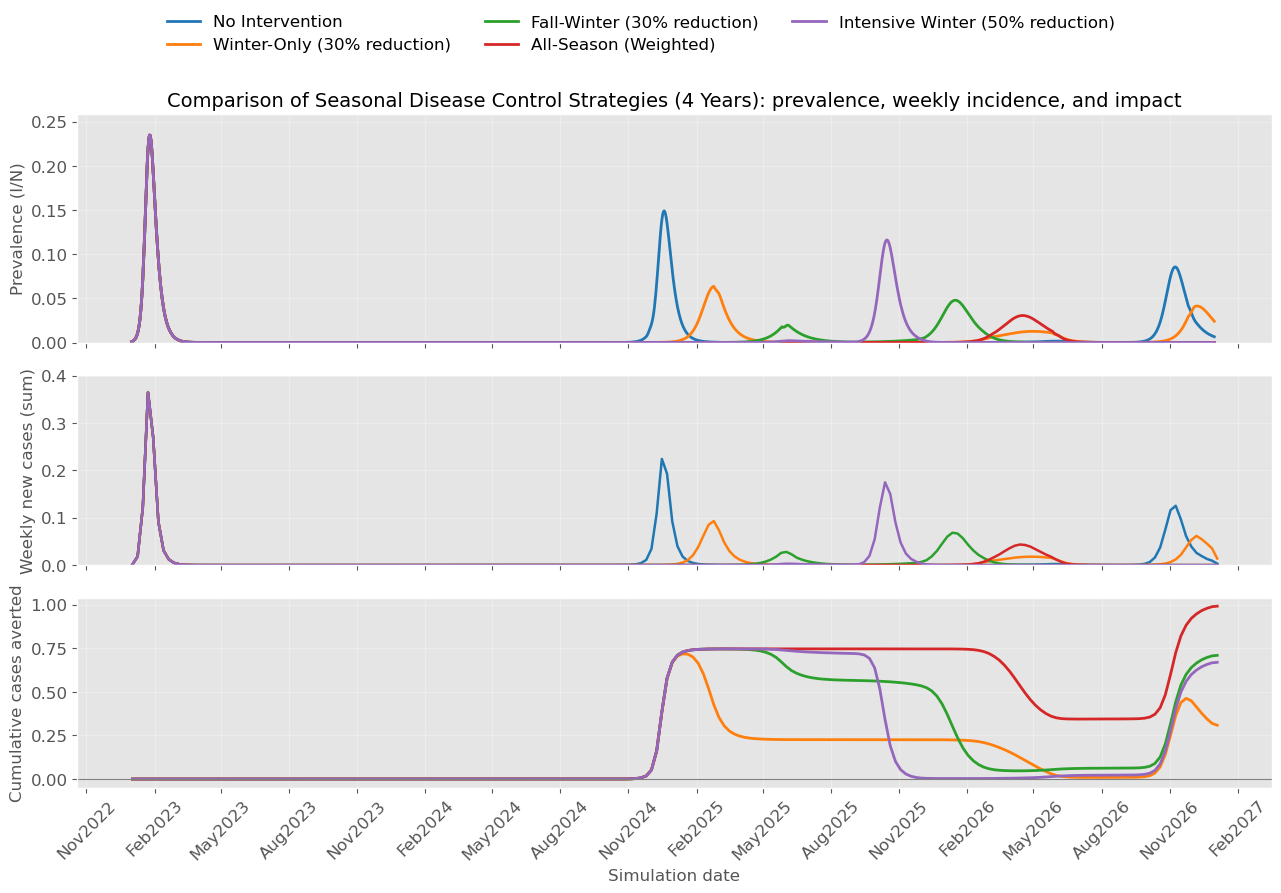

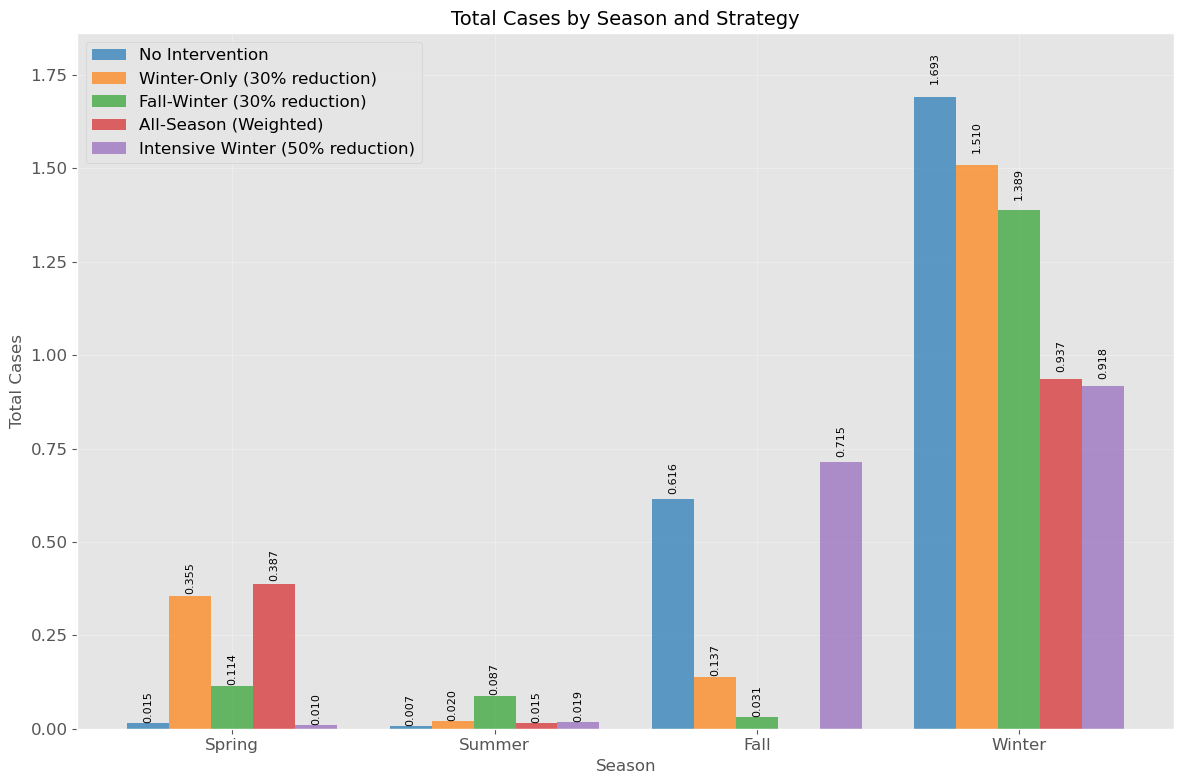

In [14]:
# 8) Execute
if __name__ == "__main__":
    results = run_quarterly_seasonal_sirs_model()

# How to switch season definitions later
# - To use equal quarters (Jan–Mar Spring, etc.), please set SEASON_MODE = 'quarter' inside run_quarterly_seasonal_sirs_model().
# - To use country-specific calendar seasons, please keep SEASON_MODE = 'calendar' and edit SEASON_BOUNDARIES_CA at the top:
#   SEASON_BOUNDARIES_CA = {
#       SPRING: (3, 1),   # Mar 1
#       SUMMER: (6, 1),   # Jun 1
#       FALL:   (9, 1),   # Sep 1
#       WINTER: (12, 1),  # Dec 1
#   }
# Now change those month/day pairs as needed (e.g., Australia, Southern Hemisphere, etc.).